In [2]:

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np
import time


In [10]:
import decoupler as dc
import pandas as pd
import sys
import pickle
import tqdm
import scipy

import pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
inference = DefaultInference(n_cpus=8)
import anndata


In [115]:
dedir = '/home/ec2-user/curation/heart_datasets/deseq/'

# Convenience functions

In [60]:
neuron_cts = ['Glia','glia','neuron','Neuron','neural','Neural','Schwann']
def build_consensus_ad(ads,filter_by = 'cell_type'):
    consensus_genes = set(ads[list(ads.keys())[0]].var_names)
    for i,dataset in enumerate(ads.keys()):
        consensus_genes = consensus_genes&set(ads[dataset].var_names)
        
    ads_filt = {}
    for i,dataset in enumerate(ads.keys()):
        ads_filt[dataset] = ads[dataset][:,list(consensus_genes)].copy()
        ads_filt[dataset].obs['dataset'] = dataset
    
        if 'age' in ads_filt[dataset].obs.columns:
            pass
        elif 'Age_bin' in ads_filt[dataset].obs.columns:
            x1 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[1].astype(float)
            x2 = ads_filt[dataset].obs['Age_bin'].str.split('-').str[0].astype(float)
            x = (x1+x2)/2
            ads_filt[dataset].obs['age'] = x
    ad=anndata.concat([ads_filt[x] for x in ads_filt.keys()])
    if filter_by=='cell_type':
        ad=ad[ad.obs['cell_type'].str.contains( "|".join(neuron_cts),regex=True)].copy()
        ad.obs['donor_id'] = ad.obs['donor_id']+'_'+ad.obs['dataset']
        ad = dc.get_pseudobulk(ad,sample_col='donor_id',groups_col=None,
            mode='sum',
            min_cells=0,
            min_counts=0,use_raw=False)
        #the "cell counts" obtained thus are not meaningful, but the counts are.
    return ad

# 1. Differential expression between male and female pseudoglia

In [61]:
with open('/home/ec2-user/curation/heart_datasets/gg_250327_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

In [62]:
ad=build_consensus_ad(ads,filter_by = 'cell_type')

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [64]:
ad.obs

,donor_id,sex,age,dataset,psbulk_n_cells,psbulk_counts
10_144396-RV_brener,10_144396-RV_brener,male,71,brener,1.0,5453.0
10_144421-RV_brener,10_144421-RV_brener,male,63,brener,1.0,279997.0
11_144422-RV_brener,11_144422-RV_brener,male,68,brener,1.0,170338.0
1221_tucker,1221_tucker,female,52,tucker,1.0,40295.0
13_144471-RV_brener,13_144471-RV_brener,male,65,brener,1.0,140987.0
...,...,...,...,...,...,...
UK1_hill,UK1_hill,female,9.0,hill,1.0,129444.0
UK2_hill,UK2_hill,female,3.0,hill,1.0,44852.0
donor_2207_selewa,donor_2207_selewa,male,54.0,selewa,1.0,636356.0
donor_2336_selewa,donor_2336_selewa,male,47.0,selewa,1.0,1049303.0


In [68]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['sex','dataset'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()


/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.03 seconds.



In [69]:
stat_res_Y_vs_X = DeseqStats(dds, contrast=["sex", "female", "male"], inference=inference,quiet=True)

In [70]:
stat_res_Y_vs_X.summary()

In [90]:
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)

In [116]:
res.to_csv(dedir+'gg_250327_f_vs_m_sd.csv')

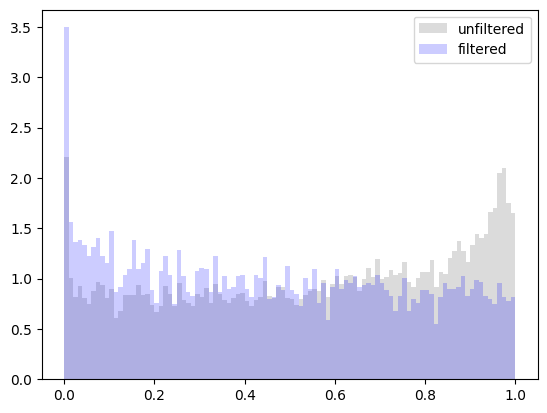

In [123]:
plt.hist(res.loc[:,'pvalue'],100,facecolor='lightgray',alpha=0.8,density=True,label='unfiltered')
plt.hist(res.loc[res['baseMean']>5,'pvalue'],100,facecolor='b',density=True,alpha=0.2,label='filtered')
plt.legend()
plt.show()

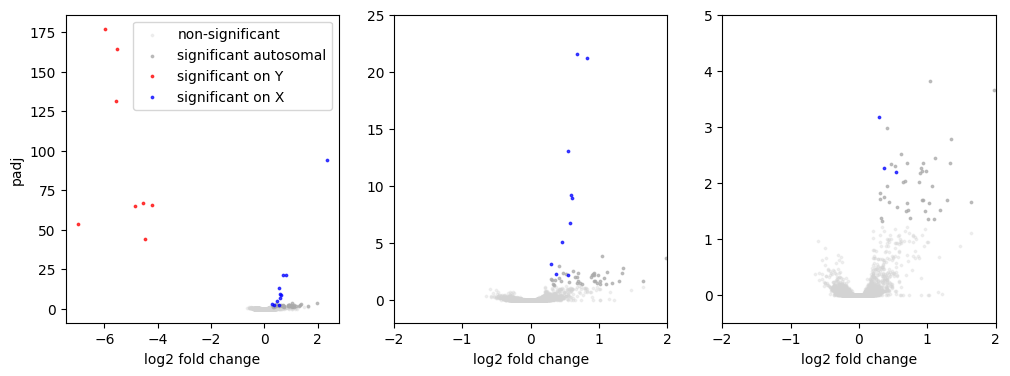

In [124]:
fig1,ax1=plt.subplots(1,3,figsize=(12,4))
gf_ = res['baseMean']>5
sig_ = (res['padj']<0.05)&(res['log2FoldChange'].abs()>0.25)
for i in range(3):
    gf = gf_&(~res['chr'].isin(['X','Y'])) & ~sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'lightgray',alpha=0.3,label='non-significant')
    gf = gf_&(~res['chr'].isin(['X','Y'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'darkgray',alpha=0.7,label='significant autosomal')
    gf = gf_&(res['chr'].isin(['Y'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'r',alpha=0.7,label='significant on Y')
    gf = gf_&(res['chr'].isin(['X'])) & sig_
    ax1[i].scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'b',alpha=0.7,label='significant on X')
    ax1[i].set_xlabel('log2 fold change')
ax1[1].set_xlim([-2,2])
ax1[1].set_ylim([-2,25])
ax1[2].set_xlim([-2,2])
ax1[2].set_ylim([-0.5,5])
ax1[0].set_ylabel('padj')
ax1[0].legend()

In [114]:
res[sig_&gf_].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
TTTY14,21.165207,-5.986057,0.208088,-28.766943,5.560854e-182,7.698446e-178,Y
UTY,19.253174,-5.528631,0.199537,-27.707253,5.709654e-169,3.952222e-165,Y
USP9Y,12.762574,-5.573970,0.224700,-24.806264,7.672980e-136,3.540825e-132,Y
XIST,72.094244,2.334291,0.111090,21.012676,5.022375e-98,1.738244e-94,X
ZFY,5.190280,-4.555626,0.255643,-17.820235,4.922915e-71,1.363057e-67,Y
TTTY10,6.227995,-4.217547,0.238767,-17.663850,7.961855e-70,1.574628e-66,Y
LINC00278,6.520530,-4.838375,0.275873,-17.538399,7.295354e-69,1.262461e-65,Y
RPS4Y1,16.199123,-6.987484,0.437702,-15.964012,2.276184e-57,3.501277e-54,Y
EIF1AY,5.115598,-4.486210,0.307316,-14.598042,2.890269e-48,4.001288e-45,Y
KDM6A,19.135233,0.677262,0.065108,10.402126,2.424633e-25,2.582048e-22,X


In [127]:
res[sig_&gf_&(res['chr']=='X')].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,72.094244,2.334291,0.111090,21.012676,5.022375e-98,1.738244e-94,X
KDM6A,19.135233,0.677262,0.065108,10.402126,2.424633e-25,2.582048e-22,X
NLGN4X,77.259218,0.819507,0.079443,10.315620,5.989330e-25,5.922591e-22,X
JPX,36.159588,0.552821,0.066504,8.312584,9.364039e-17,8.102235e-14,X
ZFX,9.902795,0.584882,0.081843,7.146372,8.910117e-13,6.852870e-10,X
AP1S2,51.588850,0.603487,0.085432,7.063934,1.618542e-12,1.179321e-09,X
CA5B,6.219907,0.580420,0.091881,6.317054,2.665959e-10,1.845377e-07,X
OFD1,10.238054,0.460854,0.081422,5.660091,1.512926e-08,9.106496e-06,X
USP9X,18.718707,0.293994,0.061377,4.789953,1.668208e-06,6.792549e-04,X
EIF2S3,14.041015,0.370486,0.086981,4.259371,2.050028e-05,5.564822e-03,X


# 2. The effects of age on expression of XIST in male pseudoglia

In [128]:
with open('/home/ec2-user/curation/heart_datasets/gg_250327_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

In [129]:
ad=build_consensus_ad(ads,filter_by = 'cell_type')

/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/ec2-user/miniconda/lib/python3.9/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [131]:
ad = ad[(ad.obs['sex']=='male')&(ad.obs['age']>0)&(ad.obs['age']<100)]

In [137]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

In [147]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['age','dataset'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["age", "", ""], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_age_ad.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:550: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:554: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:557: RuntimeW

In [148]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,28.622134,0.006959,0.003427,2.030725,0.042283,0.950113,X


In [149]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['logage','dataset'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["logage", "", ""], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_logage_logad.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:270: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(
Fitting dispersions...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 1.15 seconds.

Fitting LFCs...
... done in 1.24 seconds.



In [151]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,28.622134,0.288406,0.111628,2.583642,0.009776,0.439498,X


In [201]:
res[(res['baseMean']>10)&(res['padj']<0.05)].sort_values('padj')

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
PPARG,10.359424,0.991201,0.192298,5.154495,2.543157e-07,0.002309,3
FSTL3,17.422920,0.709573,0.154555,4.591074,4.409715e-06,0.010011,19
LRRC7,12.776384,-0.984227,0.228101,-4.314877,1.596920e-05,0.018637,1
TNXB,10.286958,0.966856,0.224394,4.308738,1.641886e-05,0.018637,6
RASGEF1B,18.622022,0.964896,0.226313,4.263549,2.012050e-05,0.020302,4
ABLIM3,11.997525,0.557540,0.132261,4.215441,2.492905e-05,0.022638,5
CADPS2,10.819636,0.687708,0.172817,3.979409,6.908667e-05,0.041825,7
RAPGEF5,19.836289,0.494255,0.124192,3.979782,6.897850e-05,0.041825,7
ZFPM2,36.023294,0.585214,0.145869,4.011926,6.022543e-05,0.041825,8
GSN,86.249895,0.526596,0.134448,3.916741,8.975422e-05,0.048581,9


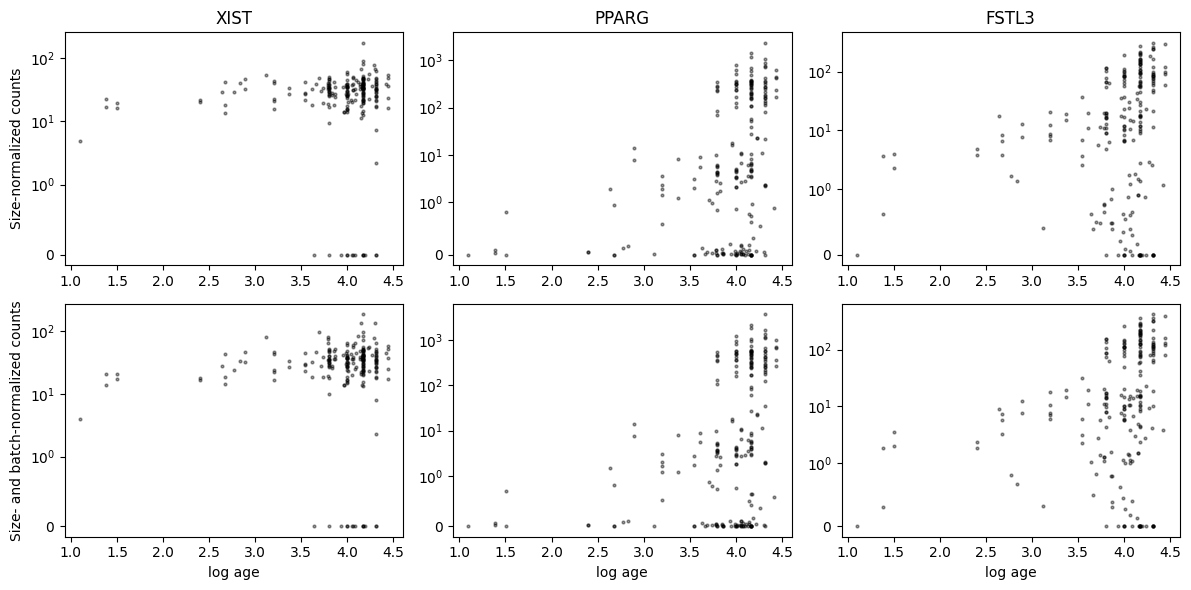

In [212]:
genes= ['XIST','PPARG','FSTL3']
fig1,ax1= plt.subplots(2,len(genes),figsize=(12,6))
for i,gene in enumerate(genes):
    y = dds[:,gene].layers['normed_counts'].squeeze()
    y_ = y/np.exp((dds.obsm['design_matrix'].iloc[:,1:-1]) @ (dds[:,gene].varm['LFC'].iloc[:,1:-1].T)).values.squeeze()
    ax1[0,i].scatter(dds.obs['logage'].astype('float'),y,4,'k',alpha=0.4)    
    ax1[0,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].scatter(dds.obs['logage'].astype('float'),y_,4,'k',alpha=0.4)    
    ax1[1,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].set_xlabel('log age')
    ax1[0,i].set_title(gene)
ax1[0,0].set_ylabel('Size-normalized counts')
ax1[1,0].set_ylabel('Size- and batch-normalized counts')
fig1.tight_layout()

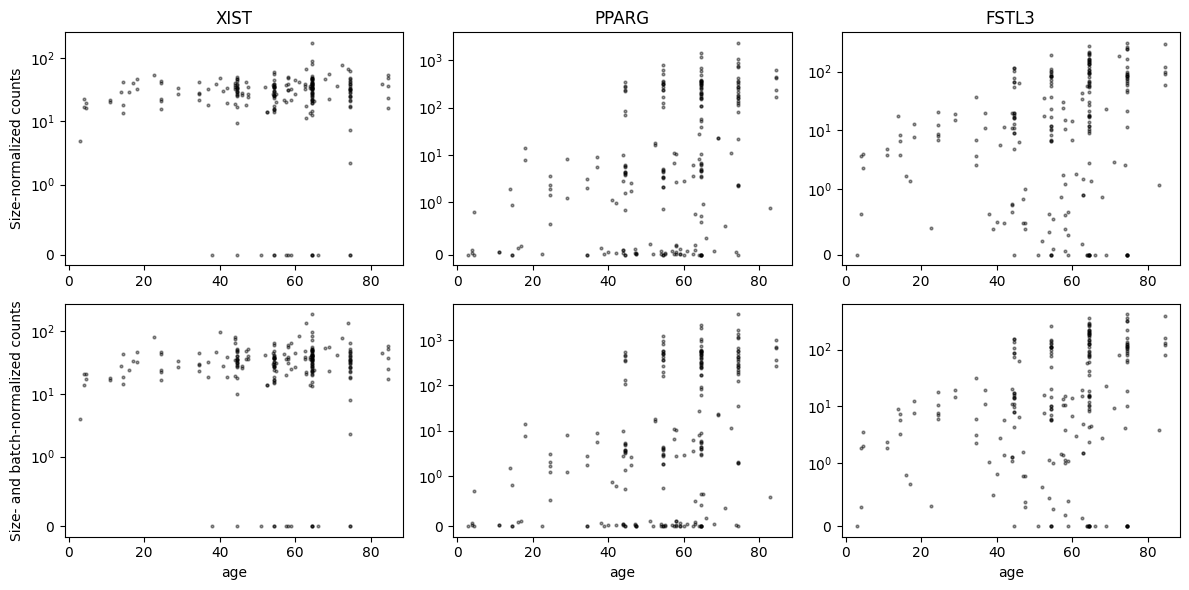

In [210]:
genes= ['XIST','PPARG','FSTL3']
fig1,ax1= plt.subplots(2,len(genes),figsize=(12,6))
for i,gene in enumerate(genes):
    y = dds[:,gene].layers['normed_counts'].squeeze()
    y_ = y/np.exp((dds.obsm['design_matrix'].iloc[:,1:-1]) @ (dds[:,gene].varm['LFC'].iloc[:,1:-1].T)).values.squeeze()
    ax1[0,i].scatter(dds.obs['age'].astype('float'),y,4,'k',alpha=0.4)    
    ax1[0,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].scatter(dds.obs['age'].astype('float'),y_,4,'k',alpha=0.4)    
    ax1[1,i].set_yscale('symlog',linthresh=1)
    ax1[1,i].set_xlabel('age')
    ax1[0,i].set_title(gene)
ax1[0,0].set_ylabel('Size-normalized counts')
ax1[1,0].set_ylabel('Size- and batch-normalized counts')
fig1.tight_layout()

# 3. The effects of pathology on expression of XIST

In [213]:
with open('/home/ec2-user/curation/heart_datasets/gg_250327_heart_celltype_psbulks.p', 'rb') as fp:
    ads = pickle.load(fp)

## Reichart

In [314]:
ads['reichart'].obs['disease'].value_counts()

disease
dilated cardiomyopathy                             505
arrhythmogenic right ventricular cardiomyopathy     79
normal                                              58
non-compaction cardiomyopathy                       10
Name: count, dtype: int64

In [238]:
ad=build_consensus_ad({'reichart':ads['reichart']},filter_by = 'cell_type')

In [220]:
ad = ad[(ad.obs['sex']=='male')]

In [223]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_reichart_dcm_p.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [224]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418168,1.027818,0.295205,3.481708,0.000498,0.032541,X


In [225]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors = ['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_reichart_dcm_pa.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [226]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418168,1.02325,0.294861,3.470273,0.00052,0.028098,X


In [228]:
ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))

/tmp/ipykernel_2956/3643726043.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['logage'] = np.log(ad.obs['age'].astype('float'))


In [229]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors = ['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "dilated cardiomyopathy", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_reichart_dcm_ploga.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [230]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,46.418168,1.041552,0.291822,3.569135,0.000358,0.022018,X


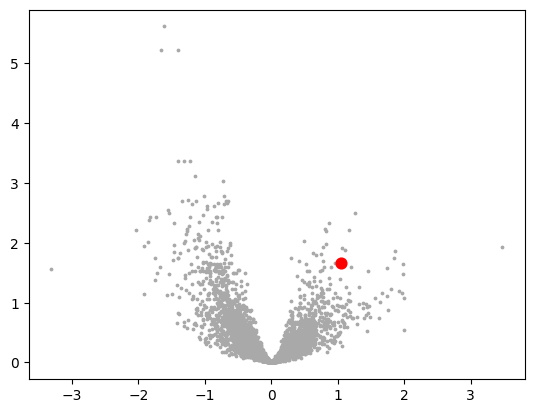

In [233]:
gf=res['baseMean']>5
plt.scatter(res.loc[gf,'log2FoldChange'],-np.log10(res.loc[gf,'padj']),3,'darkgray')
plt.scatter(res.loc["XIST",'log2FoldChange'],-np.log10(res.loc['XIST','padj']),60,'r')

## Linna-Kuosmanen

In [297]:
ad=build_consensus_ad({'linna_kuosmanen':ads['linna_kuosmanen']},filter_by = 'cell_type')

In [298]:
ad.obs['author_batch_notes'].value_counts()

author_batch_notes
Valve disease       59
IHD                 11
IHD+HF              10
CAD+MI               9
CAD                  5
Valve disease+HF     4
Name: count, dtype: int64

In [299]:
ad = ad[(ad.obs['sex']=='male')]

In [300]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_2956/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [306]:
ad.obs['pathology'] = None
ad.obs.loc[ad.obs['author_batch_notes']=='Valve disease','pathology'] = 'Valve disease'
ad.obs.loc[ad.obs['author_batch_notes']!='Valve disease','pathology'] = 'Comorbidities'

In [307]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_linna_kuosmanen_comorbidities_p.csv')

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [308]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.099108,0.273071,0.129846,2.103043,0.035462,0.97629,X


In [309]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_linna_kuosmanen_comorbidites_pa.csv')

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [310]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.099108,0.252813,0.129001,1.959775,0.050022,0.288132,X


In [311]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['pathology','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["pathology", "Comorbidities", "Valve disease"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_linna_kuosmanen_comorbidites_ploga.csv')

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [312]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,22.099108,0.251832,0.128705,1.95666,0.050388,0.228913,X


## Kuppe

In [315]:
ad=build_consensus_ad({'kuppe':ads['kuppe']},filter_by = 'cell_type')

In [316]:
ad = ad[(ad.obs['sex']=='male')]

In [317]:
ad.obs['disease'].value_counts()

disease
myocardial infarction    12
normal                    3
Name: count, dtype: int64

In [318]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_2956/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [319]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_kuppe_mci_p.csv')

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.02 seconds.



In [320]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.551374,0.927537,-0.59445,0.552211,0.999995,X


In [321]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_kuppe_mci_pa.csv')

In [322]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.709747,1.004331,-0.706686,0.479762,0.999421,X


In [323]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "myocardial infarction", "normal"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_kuppe_mci_ploga.csv')

In [324]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
feature_name,,,,,,,
XIST,20.142269,-0.680993,1.005778,-0.677081,0.498354,0.99986,X


## Simonson

In [325]:
ad=build_consensus_ad({'simonson':ads['simonson']},filter_by = 'cell_type')

In [326]:
ad = ad[(ad.obs['sex']=='male')]

In [327]:
ad.obs['disease'].value_counts()

disease
NF     4
ICM    3
Name: count, dtype: int64

In [328]:
ad.obs['age'] = ad.obs['age'].astype('float')
ad.obs['logage'] = np.log(ad.obs['age'])

/tmp/ipykernel_2956/838056906.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad.obs['age'] = ad.obs['age'].astype('float')


In [329]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_simonson_icm_p.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [330]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903638,-0.930718,0.589214,-1.579592,0.1142,0.998133,X


In [331]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','age'],
    continuous_factors=['age'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_simonson_icm_pa.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:550: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:404: RuntimeWarning: invalid value encountered in multiply
  - counts * np.log(mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:402: RuntimeWarning: invalid value encountered in subtract
  -logbinom
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:554: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(X @ beta), min_mu)
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:557: RuntimeWarning: invalid value encountered in divide
  + ((1 / disp + counts) * mu_ / (1 / disp + mu_)) @ X
/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/utils.py:550: RuntimeWarning: overflow encountered in exp
  mu_ = np.maximum(size_factors * np.exp(

In [332]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903638,-0.950768,0.68406,-1.38989,0.164562,0.996996,X


In [333]:
dds = DeseqDataSet(
    adata=ad.copy(),
    design_factors=['disease','logage'],
    continuous_factors=['logage'],
    refit_cooks=True,
    inference=inference,
    quiet=True)
dds.deseq2()
stat_res_Y_vs_X = DeseqStats(dds, contrast=["disease", "ICM", "NF"], inference=inference,quiet=True)
stat_res_Y_vs_X.summary()
res = stat_res_Y_vs_X.results_df
df_ensembl = pd.read_csv('/home/ec2-user/platform/anno/gene_details_ensembl_v104.txt',sep='\t').set_index('ensembl_id')
dict_ensembl = dict(df_ensembl[['gene_symbol', 'chromosome_name']].values)
res['chr'] = res.index.map(dict_ensembl)
res.to_csv(dedir+'gg_250327_simonson_icm_ploga.csv')

/home/ec2-user/miniconda/lib/python3.9/site-packages/pydeseq2/dds.py:727: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)


In [334]:
res.loc[['XIST']]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,chr
XIST,8.903638,-0.952827,0.673432,-1.414883,0.157103,0.999826,X
